# Censor Pinatubo from the volcanic aerosol forcing dataset used in CESM-LE

This notebook replaces aerosol mass mixing ratio data for the period associated with Pinatubo with data prior to that period, thereby eliminating the Pinatubo forcing.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## Read original forcing dataset

In [2]:
dirin = '/glade/p/cesmdata/cseg/inputdata/atm/cam/volc'
file_in = 'CCSM4_volcanic_1850-2008_prototype1.nc'
ds = xr.open_dataset(f'{dirin}/{file_in}')
ds.info()

xarray.Dataset {
dimensions:
	lat = 64 ;
	lev = 8 ;
	time = 1910 ;

variables:
	float32 time(time) ;
	float64 date(time) ;
		date:long_name = Date ;
		date:units = yyyymmdd ;
	float32 lev(lev) ;
		lev:bounds = ilev ;
		lev:long_name = Pressure downwards ;
		lev:units = hPa ;
		lev:standard_name = pure pressure levels ;
		lev:formula_terms = none ;
	float64 lat(lat) ;
	float64 MMRVOLC(time, lev, lat) ;
		MMRVOLC:units = kg kg-1 ;
		MMRVOLC:long_name = layer volcanic aerosol mass mixing ratio ;
	float32 colmass(time, lat) ;
	float64 datesec(time) ;

// global attributes:
	:title = Volcanic Aerosol Mass Mixing Ratio Prototype Dec 1849 to Jan 2009 for NCAR-CCSM4 ;
	:creation_date = Wed Apr  1 09:13:55 MDT 2009 ;
	:created_by = Caspar Ammann ;
	:reference = ... ;
	:aerosol_dates = Covered Period : Monthly averages Dec 1849 - Jan 2009. ;
	:aerosol_base = Derived from CCSM3_volcanic forcing ;
	:aerosol_distribution = Single aerosol distribution: sulfuric acid with reff 0.4264, med 0.375, sigm

Crude plots of aerosol loading

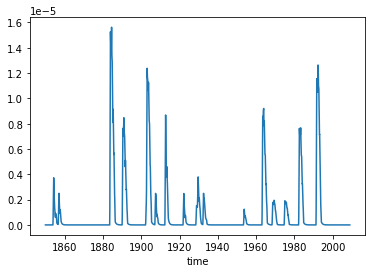

In [3]:
ds.MMRVOLC.weighted(ds.lev).sum(['lev']).mean('lat').plot()

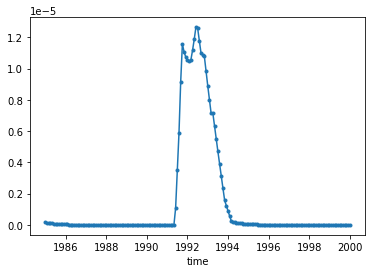

In [4]:
ds.sel(time=slice(1985, 2000)).MMRVOLC.weighted(ds.lev).sum(['lev']).mean('lat').plot(marker='.')

## Replace data for Pinatubo period

In [5]:
dso = ds.copy()
ndx_novolc = np.where((1986 <= ds.time) & (ds.time < 1991))[0]
ndx_pinatubo = np.where((1991 <= ds.time) & (ds.time < 1996))[0]
assert len(ndx_pinatubo) == len(ndx_novolc)

time_window_novolc = f'{int(ds.time.values[ndx_novolc[0]])}-{int(ds.time.values[ndx_novolc[-1]])}'
time_window_pinatubo = f'{int(ds.time.values[ndx_pinatubo[0]])}-{int(ds.time.values[ndx_pinatubo[-1]])}'
dso.attrs['Note'] = f'Original forcing data from {time_window_pinatubo} replaced with data from {time_window_novolc}'
dso.MMRVOLC.data[ndx_pinatubo, :, :] = ds.MMRVOLC.data[ndx_novolc, :, :]
dso.info()

xarray.Dataset {
dimensions:
	lat = 64 ;
	lev = 8 ;
	time = 1910 ;

variables:
	float32 time(time) ;
	float64 date(time) ;
		date:long_name = Date ;
		date:units = yyyymmdd ;
	float32 lev(lev) ;
		lev:bounds = ilev ;
		lev:long_name = Pressure downwards ;
		lev:units = hPa ;
		lev:standard_name = pure pressure levels ;
		lev:formula_terms = none ;
	float64 lat(lat) ;
	float64 MMRVOLC(time, lev, lat) ;
		MMRVOLC:units = kg kg-1 ;
		MMRVOLC:long_name = layer volcanic aerosol mass mixing ratio ;
	float32 colmass(time, lat) ;
	float64 datesec(time) ;

// global attributes:
	:title = Volcanic Aerosol Mass Mixing Ratio Prototype Dec 1849 to Jan 2009 for NCAR-CCSM4 ;
	:creation_date = Wed Apr  1 09:13:55 MDT 2009 ;
	:created_by = Caspar Ammann ;
	:reference = ... ;
	:aerosol_dates = Covered Period : Monthly averages Dec 1849 - Jan 2009. ;
	:aerosol_base = Derived from CCSM3_volcanic forcing ;
	:aerosol_distribution = Single aerosol distribution: sulfuric acid with reff 0.4264, med 0.375, sigm

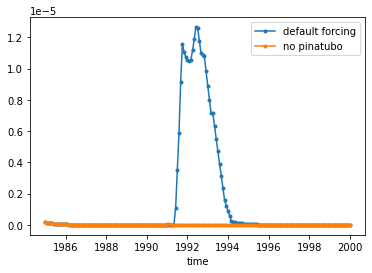

In [6]:
tslice = slice(1985, 2000)
ds.sel(time=tslice).MMRVOLC.weighted(ds.lev).sum(['lev']).mean('lat').plot(marker='.', label='default forcing')
dso.sel(time=tslice).MMRVOLC.weighted(dso.lev).sum(['lev']).mean('lat').plot(marker='.', label='no pinatubo')
plt.legend();

## Write output file

In [7]:
dirout = './data/inputdata/atm/cam/volc'
file_out = file_in.replace('.nc', '_no-pinatubo.nc')
os.makedirs(dirout, exist_ok=True)
dso.to_netcdf(f'{dirout}/{file_out}')